This is a classification problem project. Algorithms that have been chosen are decided by the course Introduction to Natural Language Processing. These are Multinomial linear regression and Naive Bayes. Both have been implemented from scratch, that is, without the use of Sklearn libraries.

### Data

We start with already separated data into train and test set. As manipulation with number of documents by classes is going to be done, it has been decided that train and test sets will be merged into one main dataset in order to do data transformations more easily.
Also, stopword dictionary is loaded and a lexicon of positive and negative words.

In [1]:
import pandas as pd
import re
import numpy as np

In [2]:
train = open('train.txt').read().split('\n')
test = open('test.txt').read().split('\n')
stopwords = set(open('stopwords.txt').read().split('\n'))
stopwords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [3]:
lex = open('lex').read().split('\n')
lexicon_neg, lexicon_pos = set(), set()

for line in lex:
    if line:
        categories = line.split(' ')
        if categories[5] == 'priorpolarity=negative':
            lexicon_neg.add(categories[2][6:])
        elif categories[5] == 'priorpolarity=positive':
            lexicon_pos.add(categories[2][6:])
            
lexicon_pos

{'renovation',
 'original',
 'satisfying',
 'knowledgeable',
 'befriend',
 'charm',
 'romanticize',
 'stimulate',
 'headway',
 'exemplar',
 'accurate',
 'kid',
 'ascendant',
 'conveniently',
 'euphoria',
 'zest',
 'compact',
 'apostle',
 'blithe',
 'enthusiast',
 'objectively',
 'fast-growing',
 'winners',
 'classic',
 'extraordinary',
 'inestimably',
 'admit',
 'incredibly',
 'importantly',
 'afford',
 'endorser',
 'fair',
 'fortitude',
 'amusingly',
 'guidance',
 'devoted',
 'memorialize',
 'sustained',
 'exhilarating',
 'incisively',
 'stunned',
 'gratitude',
 'purification',
 'supurb',
 'indulgence',
 'sensible',
 'advanced',
 'gratify',
 'congratulations',
 'ovation',
 'verifiable',
 'adorer',
 'salute',
 'jovial',
 'prepared',
 'adventuresome',
 'angelic',
 'savor',
 'tender',
 'educated',
 'inspiring',
 'strong',
 'efficiency',
 'exceed',
 'sunny',
 'gallant',
 'expertly',
 'flatter',
 'discretion',
 'openness',
 'tremendously',
 'well-established',
 'superior',
 'pinnacle',
 'u

In [4]:
train_x = [ line.split(';')[0] for line in train if line ]
train_y = [ line.split(';')[-1] for line in train if line ]

test_x = [ line.split(';')[0] for line in test if line ]
test_y = [ line.split(';')[-1] for line in test if line ]

print('number of sentences for training: ', len(train_x))
print('number of sentences for testing: ', len(test_x))

number of sentences for training:  16000
number of sentences for testing:  2000


Here, the documents (sentences) are divided into classes so that later it will be easier to take equally many sentences from each class. This is done in order to prevent having an imbalanced model. From given 6 classes (sadness, joy, love, surprise, anger, fear), only 4 are taken into consideration (sadness, joy, anger, fear) because the other two have too little documents - less than 1000. This is too little samples compared to rest of the classes which contain much more than that. If one wants to have equally many samples in each class, keeping these two classes (love, surprise) would mean cutting off too much data from other classes. We want as many samples as possible, and we want a balanced dataset because Naive Bayes and multinomial linear regression algorithms work best with such datasets.

Classes fear and anger are merged into one class named other.

In [5]:
sentences_sadness, sentences_joy, sentences_other = [], [], []

for sentence, sentiment in zip(train_x, train_y):
    if sentiment == "sadness":
        sentences_sadness.append(sentence)
    elif sentiment == "joy":
        sentences_joy.append(sentence)
    elif (sentiment == "anger" or sentiment == "fear"):
        sentences_other.append(sentence)
        
for sentence, sentiment in zip(test_x, test_y):
    if sentiment == "sadness":
        sentences_sadness.append(sentence)
    elif sentiment == "joy":
        sentences_joy.append(sentence)
    elif (sentiment == "anger" or sentiment == "fear"):
        sentences_other.append(sentence)
        
print("sadness: ", len(sentences_sadness))
print("joy: ", len(sentences_joy))
print("other: ", len(sentences_other))

print("Number of sentences ", len(sentences_sadness) + len(sentences_joy) + len(sentences_other),
      "is correct - no data is lost.")

sadness:  5247
joy:  6057
other:  4595
Number of sentences  15899 is correct - no data is lost.


In [6]:
sentences_sadness = sentences_sadness[:4595]
sentences_joy = sentences_joy[:4595]
print("sadness: ", len(sentences_sadness))
print("joy: ", len(sentences_joy))
print("other: ", len(sentences_other))
print("together: ", len(sentences_sadness) + len(sentences_joy) + len(sentences_other))

sadness:  4595
joy:  4595
other:  4595
together:  13785


In [7]:
X, y = [], []

for s in sentences_sadness:
    X.append(s)
    y.append(0)
for s in sentences_joy:
    X.append(s)
    y.append(1)
for s in sentences_other:
    X.append(s)
    y.append(2)

X

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'ive been feeling a little burdened lately wasnt sure why that was',
 'i feel like i have to make the suffering i m seeing mean something',
 'i feel low energy i m just thirsty',
 'i didnt really feel that embarrassed',
 'i feel pretty pathetic most of the time',
 'i started feeling sentimental about dolls i had as a child and so began a collection of vintage barbie dolls from the sixties',
 'i still love my so and wish the best for him i can no longer tolerate the effect that bm has on our lives and the fact that is has turned my so into a bitter angry person who is not always particularly kind to the people around him when he is feeling stressed',
 'i feel so inhibited in someone elses kitchen like im painting on someone elses picture',
 'i become overwhelmed and feel defeated',
 'i was feeling so discouraged we are already robbing peter to pay

In [8]:
df = pd.DataFrame(data=zip(X, y), columns = ['Sentence', 'Sentiment'])
df

,Sentence,Sentiment
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,ive been feeling a little burdened lately wasn...,0
3,i feel like i have to make the suffering i m s...,0
4,i feel low energy i m just thirsty,0
...,...,...
13780,i feel tortured delilahlwl am considering i ha...,2
13781,i told my fiance how i am feeling so angry and...,2
13782,i just keep feeling like someone is being unki...,2
13783,im feeling a little cranky negative after this...,2


A simple stemmer is chosen.

In [9]:
from nltk.stem.porter import PorterStemmer

STEM = PorterStemmer().stem

In [10]:
def text_process(txt):
    words = [STEM(w) for w in txt.split() if w not in stopwords]
    return words

X_processed = [text_process(sentence) for sentence in X]
X_processed

[['didnt', 'feel', 'humili'],
 ['go',
  'feel',
  'hopeless',
  'damn',
  'hope',
  'around',
  'someon',
  'care',
  'awak'],
 ['ive', 'feel', 'littl', 'burden', 'late', 'wasnt', 'sure'],
 ['feel', 'like', 'make', 'suffer', 'see', 'mean', 'someth'],
 ['feel', 'low', 'energi', 'thirsti'],
 ['didnt', 'realli', 'feel', 'embarrass'],
 ['feel', 'pretti', 'pathet', 'time'],
 ['start',
  'feel',
  'sentiment',
  'doll',
  'child',
  'began',
  'collect',
  'vintag',
  'barbi',
  'doll',
  'sixti'],
 ['still',
  'love',
  'wish',
  'best',
  'longer',
  'toler',
  'effect',
  'bm',
  'live',
  'fact',
  'turn',
  'bitter',
  'angri',
  'person',
  'alway',
  'particularli',
  'kind',
  'peopl',
  'around',
  'feel',
  'stress'],
 ['feel',
  'inhibit',
  'someon',
  'els',
  'kitchen',
  'like',
  'im',
  'paint',
  'someon',
  'els',
  'pictur'],
 ['becom', 'overwhelm', 'feel', 'defeat'],
 ['feel',
  'discourag',
  'alreadi',
  'rob',
  'peter',
  'pay',
  'paul',
  'get',
  'cow',
  'year',


In [11]:
df = pd.DataFrame(data=zip(X_processed, y), columns = ['Processed sentence', 'Sentiment'])
df

,Processed sentence,Sentiment
0,"[didnt, feel, humili]",0
1,"[go, feel, hopeless, damn, hope, around, someo...",0
2,"[ive, feel, littl, burden, late, wasnt, sure]",0
3,"[feel, like, make, suffer, see, mean, someth]",0
4,"[feel, low, energi, thirsti]",0
...,...,...
13780,"[feel, tortur, delilahlwl, consid, one, day, o...",2
13781,"[told, fianc, feel, angri, upset]",2
13782,"[keep, feel, like, someon, unkind, wrong, thin...",2
13783,"[im, feel, littl, cranki, neg, doctor, appoint]",2


### Multinomial logistic regression

For creation of feature vectors, multiple qualities of sentences will be used. One of them is word frequency by class.

In [12]:
def make_freqs(sentences):
    freqs = {}
    for sentence, sentiment in sentences:
        words = text_process(sentence)
        for w in words:
            freqs[(w, sentiment)] = freqs.get((w, sentiment), 0) + 1
    return freqs

FREQS = make_freqs(list(zip(X, y)))

data = [(w, s, FREQS[w, s]) 
        for w, s in sorted(FREQS, key=FREQS.get, reverse=True)]

pd.DataFrame(data, columns=["Word", "Sentiment", "Frequency"])

,Word,Sentiment,Frequency
0,feel,0,4918
1,feel,1,4867
2,feel,2,4812
3,like,1,893
4,like,0,871
...,...,...,...
16077,pose,2,1
16078,sadder,2,1
16079,rage,2,1
16080,delilahlwl,2,1


In [13]:
def features_extraction(txt):
    words = text_process(txt)
    x = np.array([0, 0, 0])
    for w in words:
        x[0] += FREQS.get((w, 0), 0)
        x[1] += FREQS.get((w, 1), 0)
        x[2] += FREQS.get((w, 2), 0)
    
    return x

Another sentence properties are used in order to create feature vectors. Namely: number of lexicon positive words, number of negative words, presence of the word "no" (0 if not present, 1 if it is present), and number of words in a sentence.

In [14]:
def additional_features(txt):
    words = text_process(txt)
    x = np.array([0, 0, 0, 0])
    for w in words:
        if w in lexicon_pos:
            x[0] += 1
        if w in lexicon_neg:
            x[1] += 1
        if w == "no":
            x[2] += 1
    x[3] = len(words)
    return x

Finally, another method of creating feature vectors is a combination of the previous two.

In [15]:
def all_features(txt):
    words = text_process(txt)
    x = np.array([0, 0, 0, 0, 0, 0, 0])
    for w in words:
        x[0] += FREQS.get((w, 0), 0)
        x[1] += FREQS.get((w, 1), 0)
        x[2] += FREQS.get((w, 2), 0)
        if w in lexicon_pos:
            x[3] += 1
        if w in lexicon_neg:
            x[4] += 1
        if w == "no":
            x[5] += 1
    x[6] = len(words)
    return x

In [16]:
data_additional = [(sentence, additional_features(sentence), sentiment)
                  for sentence, sentiment in list(zip(X,y))]

features_additional = np.array([d[1] for d in data_additional])

df_additional = pd.DataFrame(data_additional, columns=["Sentence", "X modified", "Sentiment"])
df_additional

,Sentence,X modified,Sentiment
0,i didnt feel humiliated,"[0, 0, 0, 3]",0
1,i can go from feeling so hopeless to so damned...,"[2, 2, 0, 9]",0
2,ive been feeling a little burdened lately wasn...,"[1, 1, 0, 7]",0
3,i feel like i have to make the suffering i m s...,"[1, 2, 0, 7]",0
4,i feel low energy i m just thirsty,"[0, 1, 0, 4]",0
...,...,...,...
13780,i feel tortured delilahlwl am considering i ha...,"[1, 1, 0, 12]",2
13781,i told my fiance how i am feeling so angry and...,"[0, 1, 0, 5]",2
13782,i just keep feeling like someone is being unki...,"[2, 3, 0, 11]",2
13783,im feeling a little cranky negative after this...,"[0, 0, 0, 7]",2


In [17]:
data_all = [(sentence, all_features(sentence), sentiment)
                  for sentence, sentiment in list(zip(X,y))]

features_all = np.array([d[1] for d in data_all])

df_all = pd.DataFrame(data_all, columns=["Sentence", "X modified", "Sentiment"])
df_all

,Sentence,X modified,Sentiment
0,i didnt feel humiliated,"[5062, 4936, 4898, 0, 0, 0, 3]",0
1,i can go from feeling so hopeless to so damned...,"[5481, 5448, 5405, 2, 2, 0, 9]",0
2,ive been feeling a little burdened lately wasn...,"[5506, 5346, 5390, 1, 1, 0, 7]",0
3,i feel like i have to make the suffering i m s...,"[6369, 6446, 6090, 1, 2, 0, 7]",0
4,i feel low energy i m just thirsty,"[5011, 4901, 4835, 0, 1, 0, 4]",0
...,...,...,...
13780,i feel tortured delilahlwl am considering i ha...,"[5633, 5533, 5576, 1, 1, 0, 12]",2
13781,i told my fiance how i am feeling so angry and...,"[4983, 4905, 4975, 0, 1, 0, 5]",2
13782,i just keep feeling like someone is being unki...,"[6755, 6677, 6716, 2, 3, 0, 11]",2
13783,im feeling a little cranky negative after this...,"[5801, 5735, 5932, 0, 0, 0, 7]",2


In [18]:
data = [(sentence, features_extraction(sentence), sentiment)
        for sentence, sentiment in list(zip(X, y))]

temp_df = pd.DataFrame(data, columns=["Sentence", "X", "Sentiment"])
temp_df

,Sentence,X,Sentiment
0,i didnt feel humiliated,"[5062, 4936, 4898]",0
1,i can go from feeling so hopeless to so damned...,"[5481, 5448, 5405]",0
2,ive been feeling a little burdened lately wasn...,"[5506, 5346, 5390]",0
3,i feel like i have to make the suffering i m s...,"[6369, 6446, 6090]",0
4,i feel low energy i m just thirsty,"[5011, 4901, 4835]",0
...,...,...,...
13780,i feel tortured delilahlwl am considering i ha...,"[5633, 5533, 5576]",2
13781,i told my fiance how i am feeling so angry and...,"[4983, 4905, 4975]",2
13782,i just keep feeling like someone is being unki...,"[6755, 6677, 6716]",2
13783,im feeling a little cranky negative after this...,"[5801, 5735, 5932]",2


In [19]:
target = np.array(y)
features = np.array([d[1] for d in data])

from sklearn.model_selection import train_test_split

train_features, test_features, train_target, test_target = train_test_split(features, target)

target.shape, train_target.shape, test_target.shape

((13785,), (10338,), (3447,))

Since feature vectors formed by second and third method have 4 and 7 coordinates, respectively, it has been decided to visually represent the vectors formed by the first method, for the simplicity of plotting. In order to represent 4 and 7 dimensional data, dimensionality reduction must be used, but it would alter the data much more significantly than dimensionality reduction on 3 dimensional data where only one dimension needs to be collapsed.

A trial with dimensionality reduction on two coordinates did not show good results (classes did not differentiate well - this is also indicative of possible classification problems that can happen down the line). This is why feature vectors were left in their original shape of 3 coordinates and plotted like that.

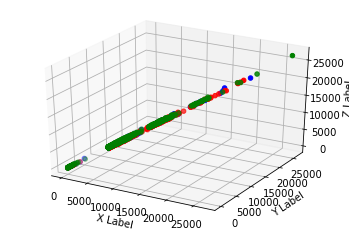

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

xs, ys, zs = [], [], []
xj, yj, zj = [], [], []
xo, yo, zo = [], [], []

for row in data:
    if row[2] == 0:
        xs.append(row[1][0])
        ys.append(row[1][1])
        zs.append(row[1][2])
    elif row[2] == 1:
        xj.append(row[1][0])
        yj.append(row[1][1])
        zj.append(row[1][2])
    elif row[2] == 2:
        xo.append(row[1][0])
        yo.append(row[1][1])
        zo.append(row[1][2])

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(xs,ys,zs, color='r')
ax.scatter(xj,yj,zj, color='b')
ax.scatter(xo,yo,zo, color='g')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

As can be seen on the plot, the data does not look separable. This is possible due to large variance in values of feature vectors - they are plotted too closely together. As plotting is not the primary focus of this project, this issue is left unsolved.

Here, basic statistic properties of feature vectors are given.

In [21]:
print('x coordinates:')
print('max sadness:', max(xs), 'max joy:', max(xj), 'max other:', max(xo))
print('min sadness:', min(xs), 'min joy:', min(xj), 'min other:', min(xo))

print('y coordinates:')
print('max sadness:', max(ys), 'max joy:', max(yj), 'max other:', max(yo))
print('min sadness:', min(ys), 'min joy:', min(yj), 'min other:', min(yo))

print('z coordinates:')
print('max sadness:', max(zs), 'max joy:', max(zj), 'max other:', max(zo))
print('min sadness:', min(zs), 'min joy:', min(zj), 'min other:', min(zo))

x coordinates:
max sadness: 21237 max joy: 21884 max other: 26931
min sadness: 11 min joy: 0 min other: 0
y coordinates:
max sadness: 20723 max joy: 21836 max other: 26523
min sadness: 4 min joy: 1 min other: 0
z coordinates:
max sadness: 20859 max joy: 21163 max other: 26590
min sadness: 3 min joy: 3 min other: 1


In [22]:
df_x = pd.DataFrame(xs+xj+xo)
df_y = pd.DataFrame(ys+yj+yo)
df_z = pd.DataFrame(zs+zj+zo)

df_x.describe(), df_y.describe(), df_z.describe()

(                  0
 count  13785.000000
 mean    5895.794342
 std     1795.742122
 min        0.000000
 25%     5128.000000
 50%     5446.000000
 75%     6025.000000
 max    26931.000000,
                   0
 count  13785.000000
 mean    5845.267320
 std     1783.873784
 min        0.000000
 25%     5069.000000
 50%     5396.000000
 75%     5980.000000
 max    26523.000000,
                   0
 count  13785.000000
 mean    5781.096119
 std     1752.568337
 min        1.000000
 25%     5023.000000
 50%     5352.000000
 75%     5897.000000
 max    26590.000000)

In [23]:
features.shape, train_features.shape, test_features.shape

((13785, 3), (10338, 3), (3447, 3))

In [24]:
features

array([[5062, 4936, 4898],
       [5481, 5448, 5405],
       [5506, 5346, 5390],
       ...,
       [6755, 6677, 6716],
       [5801, 5735, 5932],
       [6270, 6226, 6189]])

In [25]:
target

array([0, 0, 0, ..., 2, 2, 2])

Although minmax scaling has also been tried, a more commonly used method of standardization has been used because it gives better results.

In [26]:
def standard_scaler(feature_array):
    total_cols = feature_array.shape[1]
    
    for i in range(total_cols):
        feature_col = feature_array[:, i]
        mean = feature_col.mean()
        std = feature_col.std()
        print(mean, std)
        feature_array[:, i] = (feature_array[:, i] - mean) / std
        print(feature_array)

In [27]:
standard_scaler(features)
standard_scaler(train_features)
standard_scaler(test_features)

total_cols = features.shape[1]
for i in range(total_cols):
    print(features[:, i].std())

5895.794341675734 1795.6769865340434
[[   0 4936 4898]
 [   0 5448 5405]
 [   0 5346 5390]
 ...
 [   0 6677 6716]
 [   0 5735 5932]
 [   0 6226 6189]]
5845.267319550236 1783.8090796491972
[[   0    0 4898]
 [   0    0 5405]
 [   0    0 5390]
 ...
 [   0    0 6716]
 [   0    0 5932]
 [   0    0 6189]]
5781.096118969895 1752.5047678833646
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [0 0 0]
 [0 0 0]]
5892.786128845038 1786.7913377860543
[[    0  5164  5175]
 [    0  5156  5134]
 [    0  5110  5119]
 ...
 [    0  5768  5612]
 [    2 10268 10254]
 [    0  5738  5301]]
5842.216869800735 1775.6067728686505
[[    0     0  5175]
 [    0     0  5134]
 [    0     0  5119]
 ...
 [    0     0  5612]
 [    2     2 10254]
 [    0     0  5301]]
5777.859934223254 1744.3401931225148
[[0 0 0]
 [0 0 0]
 [0 0 0]
 ...
 [0 0 0]
 [2 2 2]
 [0 0 0]]
5904.81636205396 1822.036570414336
[[    0  5464  5229]
 [    0  5034  4816]
 [    3 11339 11216]
 ...
 [    0  5144  5275]
 [    0  5219  5206]
 [    2  9793  9766]]

In [28]:
weights = np.random.rand(3, 3)
biases = np.random.rand(3, 1)

In [29]:
def linear_predictor(feature_matrix, weights, biases, empty_size):
    logitScores = np.array([np.empty([empty_size]) for i in range(feature_matrix.shape[0])])
    
    for i in range(feature_matrix.shape[0]):
        logitScores[i] = (weights.dot(feature_matrix[i].reshape(-1,1)) + biases).reshape(-1)
        
    return logitScores

In [30]:
logitTest = linear_predictor(features, weights, biases, 3)
logitTest.shape

(13785, 3)

For multinomial linear regression, softmax normalizer is used instead of the sigmoid function.

In [31]:
def softmax_normalizer(logit_matrix, empty_size):
    probabilities = np.array([np.empty([empty_size]) for i in range(logit_matrix.shape[0])])
    
    for i in range(logit_matrix.shape[0]):
        exp = np.exp(logit_matrix[i])
        sum_of_arr = np.sum(exp)
        probabilities[i] = exp / sum_of_arr
        
    return probabilities

In [32]:
def multinomial_logistic_regression(features, weights, biases, empty_size):
    logit_scores = linear_predictor(features, weights, biases, empty_size)
    probabilities = softmax_normalizer(logit_scores, empty_size)
    predictions = np.array([np.argmax(i) for i in probabilities])
    
    return probabilities, predictions

In [33]:
probabilities, predictions = multinomial_logistic_regression(features, weights, biases, 3)
print(probabilities.shape)
print('Predictions: ', predictions)

(13785, 3)
Predictions:  [2 2 2 ... 2 2 2]


Accuracy with starting, random weights is given for comparison with accuracy with trained weights. Thus, we expect low accuracy here.

In [34]:
def accuracy(predictions, target):
    correct_predictions = 0
    
    for i in range(len(predictions)):
        if predictions[i] == target[i]:
            correct_predictions += 1
    
    accuracy = correct_predictions / len(predictions) * 100
    
    return accuracy

print('Current accuracy: ', accuracy(predictions, target))

Current accuracy:  32.57163583605368


In [35]:
def cross_entropy_loss(probabilities, target):
    n_samples = probabilities.shape[0]
    loss = 0
    
    for sample, i in zip(probabilities, target):
        loss += -np.log(sample[i])
        
    loss /= n_samples
    
    return loss

In order to reduce the error (finding the minimum of the cost function), stochastic gradient descent is used instead of the regular gradient descent because it has been shown to be more successful when doing multinomial linear regression learning.

In [36]:
def stochastic_gradient_descent(learning_rate, epochs, target, features, weights, biases, empty_size):
    target = target.astype(int)
    loss_list = np.array([])
    
    for i in range(epochs):
        probabilities, _ = multinomial_logistic_regression(features, weights, biases, empty_size)
        
        loss = cross_entropy_loss(probabilities, target)
        loss_list = np.append(loss_list, loss)
        
        probabilities[np.arange(features.shape[0]), target] -= 1
        
        grad_weight = probabilities.T.dot(features)
        grad_biases = np.sum(probabilities, axis = 0).reshape(-1, 1)
        
        weights -= (learning_rate * grad_weight)
        biases -= (learning_rate * grad_biases)
        
    return weights, biases, loss_list

In [37]:
updatedWeights, updatedBiases, loss_list = stochastic_gradient_descent(0.0000001, 1000, train_target, train_features, weights, biases, 3)

Here, the final accuracy metric of the model is given - on test data.

In [38]:
test_probabilities, test_predictions = multinomial_logistic_regression(test_features, updatedWeights, updatedBiases, 3)

def post_accuracy(testPredictions, testTarget):
    correctPreds = 0
    for i in range(len(testPredictions)):
        if testPredictions[i] == testTarget[i]:
            correctPreds += 1
    acc = correctPreds / len(testPredictions) * 100
    print("Model accuracy on test dataset - {}".format(acc))
    
post_accuracy(test_predictions, test_target)

Model accuracy on test dataset - 32.84015085581665


Accuracy, precision, recall and F-measure are calculated by using macro average.

In [39]:
def conf_matrix(actual, predicted):
    a11 , a12, a13, a21, a22, a23, a31, a32, a33 = 0, 0, 0, 0, 0, 0, 0, 0, 0
    accuracy, precision, recall, F_measure = 0, 0, 0, 0
    
    for i in range(len(predicted)):
        if actual[i] == predicted[i]:
            if actual[i] == 0:
                a11 += 1
            elif actual[i] == 1:
                a22 += 1
            else:
                a33 += 1
        else:
            if actual[i] == 0:
                if predicted[i] == 1:
                    a21 += 1
                elif predicted[i] == 2:
                    a31 += 1
            elif actual[i] == 1:
                if predicted[i] == 0:
                    a12 += 1
                elif predicted[i] == 2:
                    a32 += 1
            else:
                if predicted[i] == 0:
                    a13 += 1
                elif predicted[i] == 1:
                    a23 += 1
    #print(a11 , a12, a13, a21, a22, a23, a31, a32, a33)
    
    acc_sadness = (a11 + a22 + a23 + a32 + a33) / (a11 + a12 + a13 + a21 + a22 + a23 + a31 + a32 + a33)
    acc_joy = (a22 + a11 + a13 + a31 + a33) / (a11 + a12 + a13 + a21 + a22 + a23 + a31 + a32 + a33)
    acc_other = (a33 + a11 + a12 + a21 + a22) / (a11 + a12 + a13 + a21 + a22 + a23 + a31 + a32 + a33)
    accuracy = (acc_sadness + acc_joy + acc_other) / 3
    
    if (a11 + a12 + a13) == 0:
        prec_sadness = 1
    else:
        prec_sadness = (a11) / (a11 + a12 + a13)
    if (a22 + a21 + a23) == 0:
        prec_joy = 1
    else:
        prec_joy = (a22) / (a22 + a21 + a23)
    if (a33 + a31 + a32) == 0:
        prec_other = 1
    else:
        prec_other = (a33) / (a33 + a31 + a32)
    precision = (prec_sadness + prec_joy + prec_other) / 3
    
    if (a11 + a21 + a31) == 0:
        rec_sadness = 1
    else:
        rec_sadness = (a11) / (a11 + a21 + a31)
    if (a22 + a12 + a32) == 0:
        rec_joy = 1
    else:
        rec_joy = (a22) / (a22 + a12 + a32)
    if (a33 + a13 + a23) == 0:
        rec_other = 1
    else:
        rec_other = (a33) / (a33 + a13 + a23)
    recall = (rec_sadness + rec_joy + rec_other) / 3
    
    F_sadness = (2*prec_sadness*rec_sadness) / (prec_sadness + rec_sadness)
    F_joy = (2*prec_joy*rec_joy) / (prec_joy + rec_joy)
    F_other = (2*prec_other*rec_other) / (prec_other + rec_other)
    F_measure = (F_sadness + F_joy + F_other) / 3
    
    return accuracy, precision, recall, F_measure

In [40]:
print('~ macro average ~')
print('accuracy:', conf_matrix(test_target, test_predictions)[0])
print('precision:', conf_matrix(test_target, test_predictions)[1])
print('recall:', conf_matrix(test_target, test_predictions)[2])
print('F measure:', conf_matrix(test_target, test_predictions)[3])

~ macro average ~
accuracy: 0.552267672372111
precision: 0.2721793618474171
recall: 0.323390811537038
F measure: 0.20617052526319135


We train another model, this time using other two kinds of feature vectors that were explained earlier.

In [41]:
train_features, test_features, train_target, test_target = train_test_split(features_additional, target)
target.shape, train_target.shape, test_target.shape, train_features.shape, test_features.shape

((13785,), (10338,), (3447,), (10338, 4), (3447, 4))

In [42]:
standard_scaler(features_additional)
standard_scaler(train_features)
standard_scaler(test_features)

total_cols = features_additional.shape[1]
for i in range(total_cols):
    print(features_additional[:, i].std())

1.0090678273485674 1.1469429655555319
[[ 0  0  0  3]
 [ 0  2  0  9]
 [ 0  1  0  7]
 ...
 [ 0  3  0 11]
 [ 0  0  0  7]
 [ 0  1  0 12]]
0.8420021762785637 0.9868883160811368
[[ 0  0  0  3]
 [ 0  1  0  9]
 [ 0  0  0  7]
 ...
 [ 0  2  0 11]
 [ 0  0  0  7]
 [ 0  0  0 12]]
0.0 0.0
[[          0           0 -2147483648           3]
 [          0           1 -2147483648           9]
 [          0           0 -2147483648           7]
 ...
 [          0           2 -2147483648          11]
 [          0           0 -2147483648           7]
 [          0           0 -2147483648          12]]
9.277112803772216 5.2219468579520525
[[          0           0 -2147483648          -1]
 [          0           1 -2147483648           0]
 [          0           0 -2147483648           0]
 ...
 [          0           2 -2147483648           0]
 [          0           0 -2147483648           0]
 [          0           0 -2147483648           0]]
1.0133488102147417 1.1509313002193338
[[ 0  1  0 10]
 [ 0  0  0

<ipython-input-26-4b1b7b9ce209>:9: RuntimeWarning: invalid value encountered in true_divide
  feature_array[:, i] = (feature_array[:, i] - mean) / std


In [43]:
weights = np.random.rand(4, 4)
biases = np.random.rand(4, 1)

In [44]:
logitTest = linear_predictor(features_additional, weights, biases, 4)
logitTest.shape

(13785, 4)

In [45]:
probabilities, predictions = multinomial_logistic_regression(features_additional, weights, biases, 4)
print(probabilities.shape)
print('Predictions: ', predictions)

(13785, 4)
Predictions:  [0 0 0 ... 0 0 0]


<ipython-input-31-4f19524a6891>:7: RuntimeWarning: invalid value encountered in true_divide
  probabilities[i] = exp / sum_of_arr


In [46]:
print('Current accuracy: ', accuracy(predictions, target))

Current accuracy:  33.33333333333333


In [47]:
updatedWeights, updatedBiases, loss_list = stochastic_gradient_descent(0.0000001, 1000, train_target, train_features, weights, biases, 4)

<ipython-input-31-4f19524a6891>:7: RuntimeWarning: invalid value encountered in true_divide
  probabilities[i] = exp / sum_of_arr


In [48]:
test_probabilities, test_predictions = multinomial_logistic_regression(test_features, updatedWeights, updatedBiases, 4)

post_accuracy(test_predictions, test_target)

Model accuracy on test dataset - 32.69509718595881


In [49]:
print('~ macro average ~')
print('accuracy:', conf_matrix(test_target, test_predictions)[0])
print('precision:', conf_matrix(test_target, test_predictions)[1])
print('recall:', conf_matrix(test_target, test_predictions)[2])
print('F measure:', conf_matrix(test_target, test_predictions)[3])

~ macro average ~
accuracy: 0.5513006479063921
precision: 0.775650323953196
recall: 0.3333333333333333
F measure: 0.16426176942136714


In [50]:
train_features, test_features, train_target, test_target = train_test_split(features_all, target)
target.shape, train_target.shape, test_target.shape, train_features.shape, test_features.shape

standard_scaler(features_all)
standard_scaler(train_features)
standard_scaler(test_features)

total_cols = features.shape[1]
for i in range(total_cols):
    print(features[:, i].std())

5895.794341675734 1795.6769865340434
[[   0 4936 4898 ...    0    0    3]
 [   0 5448 5405 ...    2    0    9]
 [   0 5346 5390 ...    1    0    7]
 ...
 [   0 6677 6716 ...    3    0   11]
 [   0 5735 5932 ...    0    0    7]
 [   0 6226 6189 ...    1    0   12]]
5845.267319550236 1783.8090796491972
[[   0    0 4898 ...    0    0    3]
 [   0    0 5405 ...    2    0    9]
 [   0    0 5390 ...    1    0    7]
 ...
 [   0    0 6716 ...    3    0   11]
 [   0    0 5932 ...    0    0    7]
 [   0    0 6189 ...    1    0   12]]
5781.096118969895 1752.5047678833646
[[ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  2  0  9]
 [ 0  0  0 ...  1  0  7]
 ...
 [ 0  0  0 ...  3  0 11]
 [ 0  0  0 ...  0  0  7]
 [ 0  0  0 ...  1  0 12]]
1.0090678273485674 1.1469429655555319
[[ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  2  0  9]
 [ 0  0  0 ...  1  0  7]
 ...
 [ 0  0  0 ...  3  0 11]
 [ 0  0  0 ...  0  0  7]
 [ 0  0  0 ...  1  0 12]]
0.8420021762785637 0.9868883160811368
[[ 0  0  0 ...  0  0  3]
 [ 0  0  0 ...  1  0

<ipython-input-26-4b1b7b9ce209>:9: RuntimeWarning: invalid value encountered in true_divide
  feature_array[:, i] = (feature_array[:, i] - mean) / std


In [51]:
weights = np.random.rand(7, 7)
biases = np.random.rand(7, 1)

In [52]:
logitTest = linear_predictor(features_all, weights, biases, 7)
logitTest.shape

(13785, 7)

In [53]:
probabilities, predictions = multinomial_logistic_regression(features_all, weights, biases, 7)
print(probabilities.shape)
print('Predictions: ', predictions)

(13785, 7)
Predictions:  [0 0 0 ... 0 0 0]


<ipython-input-31-4f19524a6891>:7: RuntimeWarning: invalid value encountered in true_divide
  probabilities[i] = exp / sum_of_arr


In [54]:
print('Current accuracy: ', accuracy(predictions, target))

Current accuracy:  33.33333333333333


In [55]:
updatedWeights, updatedBiases, loss_list = stochastic_gradient_descent(0.0000001, 1000, train_target, train_features, weights, biases, 7)

<ipython-input-31-4f19524a6891>:7: RuntimeWarning: invalid value encountered in true_divide
  probabilities[i] = exp / sum_of_arr


In [56]:
test_probabilities, test_predictions = multinomial_logistic_regression(test_features, updatedWeights, updatedBiases, 7)

post_accuracy(test_predictions, test_target)

Model accuracy on test dataset - 33.56541920510589


In [57]:
print('~ macro average ~')
print('accuracy:', conf_matrix(test_target, test_predictions)[0])
print('precision:', conf_matrix(test_target, test_predictions)[1])
print('recall:', conf_matrix(test_target, test_predictions)[2])
print('F measure:', conf_matrix(test_target, test_predictions)[3])

~ macro average ~
accuracy: 0.557102794700706
precision: 0.778551397350353
recall: 0.3333333333333333
F measure: 0.16753547639733565


As it can be seen in upper results, all three kinds of feature vectors unfortunately give similar bad results. After trying out different kinds of scaling the data and adjusting the learning step parameters, as well as iterations in gradient descent, did not improve model accuracy, it was concluded that either linear regression is not suitable for the data or that the data is not separable.

### Naive Bayes

In [58]:
X_processed

[['didnt', 'feel', 'humili'],
 ['go',
  'feel',
  'hopeless',
  'damn',
  'hope',
  'around',
  'someon',
  'care',
  'awak'],
 ['ive', 'feel', 'littl', 'burden', 'late', 'wasnt', 'sure'],
 ['feel', 'like', 'make', 'suffer', 'see', 'mean', 'someth'],
 ['feel', 'low', 'energi', 'thirsti'],
 ['didnt', 'realli', 'feel', 'embarrass'],
 ['feel', 'pretti', 'pathet', 'time'],
 ['start',
  'feel',
  'sentiment',
  'doll',
  'child',
  'began',
  'collect',
  'vintag',
  'barbi',
  'doll',
  'sixti'],
 ['still',
  'love',
  'wish',
  'best',
  'longer',
  'toler',
  'effect',
  'bm',
  'live',
  'fact',
  'turn',
  'bitter',
  'angri',
  'person',
  'alway',
  'particularli',
  'kind',
  'peopl',
  'around',
  'feel',
  'stress'],
 ['feel',
  'inhibit',
  'someon',
  'els',
  'kitchen',
  'like',
  'im',
  'paint',
  'someon',
  'els',
  'pictur'],
 ['becom', 'overwhelm', 'feel', 'defeat'],
 ['feel',
  'discourag',
  'alreadi',
  'rob',
  'peter',
  'pay',
  'paul',
  'get',
  'cow',
  'year',


We use a bag of words - order of words is deemed irrelevant, and only frequency by class is taken into consideration.

In [59]:
bow = {}
for sentence in X_processed:
    for word in sentence:
        bow[word] = bow.get(word, 0) + 1
bow

{'didnt': 248,
 'feel': 14597,
 'humili': 51,
 'go': 778,
 'hopeless': 68,
 'damn': 35,
 'hope': 225,
 'around': 267,
 'someon': 223,
 'care': 120,
 'awak': 21,
 'ive': 514,
 'littl': 644,
 'burden': 78,
 'late': 118,
 'wasnt': 86,
 'sure': 205,
 'like': 2493,
 'make': 808,
 'suffer': 61,
 'see': 356,
 'mean': 137,
 'someth': 453,
 'low': 87,
 'energi': 60,
 'thirsti': 3,
 'realli': 782,
 'embarrass': 70,
 'pretti': 336,
 'pathet': 53,
 'time': 824,
 'start': 396,
 'sentiment': 35,
 'doll': 6,
 'child': 69,
 'began': 51,
 'collect': 14,
 'vintag': 7,
 'barbi': 3,
 'sixti': 2,
 'still': 503,
 'love': 492,
 'wish': 94,
 'best': 92,
 'longer': 57,
 'toler': 9,
 'effect': 31,
 'bm': 1,
 'live': 215,
 'fact': 91,
 'turn': 93,
 'bitter': 61,
 'angri': 129,
 'person': 261,
 'alway': 294,
 'particularli': 65,
 'kind': 199,
 'peopl': 577,
 'stress': 182,
 'inhibit': 29,
 'els': 95,
 'kitchen': 14,
 'im': 2101,
 'paint': 24,
 'pictur': 52,
 'becom': 115,
 'overwhelm': 100,
 'defeat': 53,
 'disco

We calculate prior probabilites for each class.

In [60]:
P_sadness = len(sentences_sadness) / (len(sentences_sadness) + len(sentences_joy) + len(sentences_other))
P_joy = len(sentences_joy) / (len(sentences_sadness) + len(sentences_joy) + len(sentences_other))
P_other = len(sentences_other) / (len(sentences_sadness) + len(sentences_joy) + len(sentences_other))
P_sadness, P_joy, P_other

(0.3333333333333333, 0.3333333333333333, 0.3333333333333333)

We take a size of the dictionary - number of unique words from the bag of words.

In [61]:
size_V = len(bow.keys())
print('number of unique words:', size_V)

number of unique words: 9517


Now we calculate word frequencies by class.

In [62]:
probabilities_sadness, probabilities_joy, probabilities_other = {}, {}, {}

for sentence, sentiment in zip(X_processed, y):
    if sentiment == 0:
        for word in sentence:
            probabilities_sadness[word] = probabilities_sadness.get(word, 0) + 1
    elif sentiment == 1:
        for word in sentence:
            probabilities_joy[word] = probabilities_joy.get(word, 0) + 1
    else:
        for word in sentence:
            probabilities_other[word] = probabilities_other.get(word, 0) + 1
        
probabilities_other

{'im': 746,
 'grab': 12,
 'minut': 17,
 'post': 52,
 'feel': 4812,
 'greedi': 73,
 'wrong': 91,
 'grouchi': 28,
 'confus': 58,
 'life': 124,
 'teenag': 9,
 'jade': 2,
 'year': 76,
 'old': 43,
 'man': 27,
 'think': 225,
 'easiest': 1,
 'time': 278,
 'dissatisfi': 61,
 'compromis': 2,
 'skeptic': 38,
 'valu': 4,
 'everi': 72,
 'unit': 1,
 'work': 120,
 'put': 59,
 'irrit': 149,
 'reject': 4,
 'without': 68,
 'anyon': 41,
 'anyth': 67,
 'say': 139,
 'complet': 40,
 'overwhelm': 74,
 'two': 38,
 'strategi': 3,
 'help': 98,
 'ground': 18,
 'pour': 4,
 'heart': 45,
 'journal': 4,
 'form': 7,
 'letter': 4,
 'god': 44,
 'end': 61,
 'list': 11,
 'five': 3,
 'thing': 222,
 'grate': 12,
 'alreadi': 43,
 'like': 729,
 'fuck': 84,
 'though': 76,
 'dont': 150,
 'usual': 38,
 'eat': 38,
 'morn': 28,
 'kinda': 17,
 'appal': 14,
 'need': 136,
 'explain': 9,
 'wide': 4,
 'lenghth': 1,
 'bodi': 33,
 'measur': 2,
 'etc': 14,
 'pp': 1,
 'rememb': 69,
 'acut': 1,
 'distress': 37,
 'day': 167,
 'climb': 7,
 

Here we calculate probabilities by word frequencies.

In [63]:
probabilities = {}
for word in bow:
    probabilities[word] = [(0, (probabilities_sadness.get(word, 1)) / (3 + size_V)),
                          (1, (probabilities_joy.get(word, 1)) / (3 + size_V)),
                          (2, (probabilities_other.get(word, 1)) / (3 + size_V))]
probabilities

{'didnt': [(0, 0.009978991596638655),
  (1, 0.00703781512605042),
  (2, 0.009033613445378152)],
 'feel': [(0, 0.5165966386554622),
  (1, 0.5112394957983193),
  (2, 0.5054621848739496)],
 'humili': [(0, 0.005147058823529412),
  (1, 0.0002100840336134454),
  (2, 0.0001050420168067227)],
 'go': [(0, 0.024474789915966386),
  (1, 0.02804621848739496),
  (2, 0.029201680672268908)],
 'hopeless': [(0, 0.006407563025210084),
  (1, 0.0001050420168067227),
  (2, 0.0007352941176470588)],
 'damn': [(0, 0.0013655462184873949),
  (1, 0.0011554621848739496),
  (2, 0.0011554621848739496)],
 'hope': [(0, 0.006617647058823529),
  (1, 0.012710084033613445),
  (2, 0.0043067226890756306)],
 'around': [(0, 0.007457983193277311),
  (1, 0.008298319327731092),
  (2, 0.012289915966386554)],
 'someon': [(0, 0.007457983193277311),
  (1, 0.006092436974789916),
  (2, 0.009873949579831932)],
 'care': [(0, 0.004516806722689076),
  (1, 0.003991596638655462),
  (2, 0.004096638655462185)],
 'awak': [(0, 0.000840336134453

In [64]:
def segment_word(txt):
    sents = re.split(r'[\.\,\?\!\s]', txt)
    sents = [s.strip('"\'()[] ') for s in sents if s.strip() != '']
    return sents

Lastly, we calculate posterior probability. We use logarithms in order to secure numerical stability (by avoiding zeroes) because the numbers are large.

In [65]:
import math

def find_posterior(data, P_class, n_class):
    posterior = {}
    for sentence in data:
        posterior[sentence] = math.log(P_class)
        for word in segment_word(sentence):
            if word not in stopwords:
                w = STEM(word)
                posterior[sentence] += math.log(probabilities[w][n_class][1])
                posterior[sentence] = round(posterior[sentence], 5)
        
    return posterior

posterior_sadness = find_posterior(X, P_sadness, 0)
posterior_joy = find_posterior(X, P_joy, 1)
posterior_other = find_posterior(X, P_other, 2)

result = {}
for sentence in X:
    maks = {"sadness": posterior_sadness[sentence], "joy": posterior_joy[sentence], "other": posterior_other[sentence]}
    result[sentence] = result.get(sentence, max(maks, key=maks.get))
result

{'i didnt feel humiliated': 'sadness',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake': 'sadness',
 'ive been feeling a little burdened lately wasnt sure why that was': 'sadness',
 'i feel like i have to make the suffering i m seeing mean something': 'sadness',
 'i feel low energy i m just thirsty': 'sadness',
 'i didnt really feel that embarrassed': 'sadness',
 'i feel pretty pathetic most of the time': 'sadness',
 'i started feeling sentimental about dolls i had as a child and so began a collection of vintage barbie dolls from the sixties': 'sadness',
 'i still love my so and wish the best for him i can no longer tolerate the effect that bm has on our lives and the fact that is has turned my so into a bitter angry person who is not always particularly kind to the people around him when he is feeling stressed': 'other',
 'i feel so inhibited in someone elses kitchen like im painting on someone elses picture': 'sadness',
 

Based on posterior probabilities, we classify the sentences. Results are given below.

In [66]:
print("Number of sentences classified as 'sadness':", len([sentence for sentence in X if result[sentence] == "sadness"]))
print("Number of sentences classified as 'joy':", len([sentence for sentence in X if result[sentence] == "joy"]))
print("Number of sentences classified as 'other':", len([sentence for sentence in X if result[sentence] == "other"]))

Number of sentences classified as 'sadness': 4586
Number of sentences classified as 'joy': 4608
Number of sentences classified as 'other': 4591


In [67]:
predictions = []
for v in result.values():
    if v == "sadness":
        predictions.append(0)
    elif v == "joy":
        predictions.append(1)
    else:
        predictions.append(2)
predictions

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [68]:
conf_matrix(y, predictions)
print('~ macro average ~')
print('accuracy:', conf_matrix(y, predictions)[0])
print('precision:', conf_matrix(y, predictions)[1])
print('recall:', conf_matrix(y, predictions)[2])
print('F measure:', conf_matrix(y, predictions)[3])

~ macro average ~
accuracy: 0.9602690669763841
precision: 0.9403923803268714
recall: 0.9404010819068805
F measure: 0.940395696734976
